# Linear Regression with TensorFlow

TensorFlow operations (also called **ops** for short) can take any number of inputs and produce any number of outputs. For example, the addition and multiplication ops each take two inputs and produce one output. 

For example, the addition and multiplication ops each take two inputs and produce one output. Constants and variables take no input (they are called **source ops**). 

The inputs and outputs are **multidimensional arrays**, called `tensors` (hence the name **“tensor flow”**).

Just like NumPy arrays, tensors have a type and a shape. In fact, in the Python API tensors are simply represented by NumPy ndarrays. They typically contain floats, but you can also use them to carry strings (arbitrary byte arrays).

For example, the following code manipulates 2D arrays to perform Linear Regression on the California housing data‐ set

<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=default"></script>

It starts by fetching the dataset; then it adds an extra bias input feature (`x0 = 1`) to all training instances (it does so using NumPy so it runs immediately); 

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
m,n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]

/Users/caihaocui/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Then it creates two TensorFlow constant nodes, `X` and `y`, to hold this data and the targets, and it uses some of the matrix operations provided by TensorFlow to define theta. 

These matrix functions—`transpose()`, `matmul()`, and `matrix_inverse()`— are self-explanatory, but as usual they do not perform any computations immediately; instead, they create nodes in the graph that will perform them when the graph is run. 

You may recognize that the definition of `theta` corresponds to the Normal Equation
$$\theta = (X^{T} X)^{-1}X^{T}y$$

In [2]:
X = tf.constant(housing_data_plus_bias, dtype = tf.float32, name = 'X')
y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = 'y')
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)),XT), y)  
y_pred = tf.matmul(X, theta)

**Note** that housing.target is a 1D array, but we need to reshape it to a column vector to compute theta. 
Recall that NumPy’s reshape() function accepts –1 (meaning “unspecified”) for one of the dimensions: that dimension will be computed based on the array’s length and the remaining dimensions.

In [3]:
print(housing.target.shape)
print(housing.target.reshape(-1,1).shape)

(20640,)
(20640, 1)


Finally, the code creates a session and uses it to evaluate theta.

In [4]:
with tf.Session() as sess:
    theta_value = theta.eval()
    y_pred_value = y_pred.eval()
    
print(theta_value)

[[-3.7185181e+01]
 [ 4.3633747e-01]
 [ 9.3952334e-03]
 [-1.0711310e-01]
 [ 6.4479220e-01]
 [-4.0338000e-06]
 [-3.7813708e-03]
 [-4.2348403e-01]
 [-4.3721911e-01]]


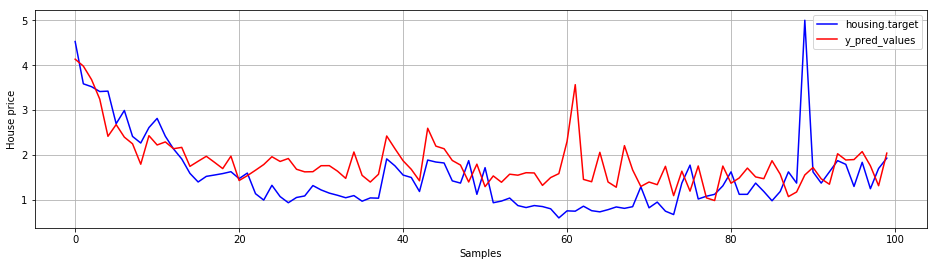

In [5]:
import matplotlib.pyplot as plt
# By running this special iPython command, we will be displaying plots inline:
%matplotlib inline 

id_sample = range(100);
plt.figure(figsize=(16, 4))
plt.plot(housing.target[id_sample], 'b', label = 'housing.target')
plt.plot(y_pred_value[id_sample], 'r', label = 'y_pred_values')
plt.ylabel('House price')
plt.xlabel('Samples')
plt.legend()
plt.grid(True)
plt.show()

The main benefit of this code versus computing the Normal Equation directly using NumPy is that TensorFlow will automatically run this on your GPU card if you have one.

We could also use other methods:

In [6]:
# Using Numpy
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


In [7]:
# Using Sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


# Implementing Gradient Descent

Let’s try using `Batch Gradient Descent` instead of the `Normal Equation`. 
First we will do this by manually computing the gradients, then we will use `TensorFlow’s autodiff` feature to let TensorFlow compute the gradients automatically, and finally we will use a couple of TensorFlow’s out-of-the-box optimizers.

**Note**: When using Gradient Descent, remember that it is important to first normalize the input feature vectors, or else training may be much slower. You can do this using TensorFlow, NumPy, Scikit-Learn’s StandardScaler, or any other solution you prefer. The following code assumes that this normalization has already been done.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


## Manually Computing the Gradients

The following code should be fairly self-explanatory, except for a few new elements:
- The `random_uniform()` function creates a node in the graph that will generate a tensor containing random values, given its shape and value range, much like NumPy’s rand() function.
- The `assign()` function creates a node that will assign a new value to a variable. In this case, it implements the Batch Gradient Descent step $\theta^{next step} = \theta –  \bigtriangledown_{\theta}MSE(\theta)$.
- The main loop executes the training step over and over again (n_epochs times), and every 100 iterations it prints out the current Mean Squared Error (mse). 
You should see the MSE go down at every iteration.

In [9]:
# reset the tensorflow graph
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype = tf.float32, name = 'X')
y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = 'y')
theta  =  tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name = 'theta')
y_pred = tf.matmul(X, theta, name = 'predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name = 'mse')

gradients = 2.0/m*tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate*gradients)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)        
    y_pred_value = y_pred.eval()    
    best_theta = theta.eval()

print("best_theta:")    
print(best_theta)

# something went wrong here, I need to check why the mse is 'non'

Epoch 0 MSE = 4.5605946
Epoch 100 MSE = 0.6621478
Epoch 200 MSE = 0.55933756
Epoch 300 MSE = 0.54719484
Epoch 400 MSE = 0.5408755
Epoch 500 MSE = 0.53642464
Epoch 600 MSE = 0.53319454
Epoch 700 MSE = 0.53084105
Epoch 800 MSE = 0.52912414
Epoch 900 MSE = 0.5278687
[[ 2.0685523e+00]
 [ 8.2816613e-01]
 [ 1.3655990e-01]
 [-2.2896209e-01]
 [ 2.6058701e-01]
 [ 1.9935346e-03]
 [-4.0801551e-02]
 [-7.7142507e-01]
 [-7.4027532e-01]]


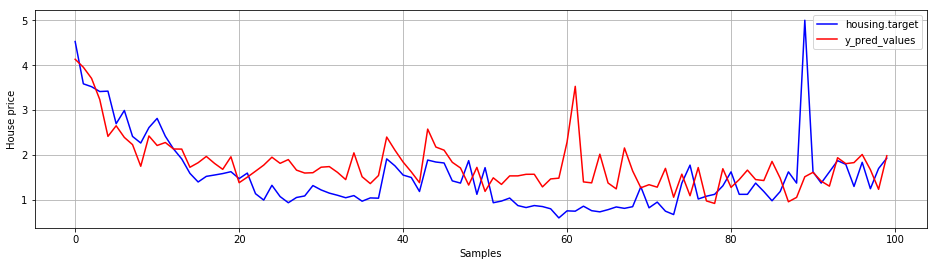

In [10]:
id_sample = range(100);
plt.figure(figsize=(16, 4))
plt.plot(housing.target[id_sample], 'b', label = 'housing.target')
plt.plot(y_pred_value[id_sample], 'r', label = 'y_pred_values')
plt.ylabel('House price')
plt.xlabel('Samples')
plt.legend()
plt.grid(True)
plt.show()

## Using autodiff

The preceding code works fine, but it requires mathematically deriving the gradients from the cost function (MSE). In the case of Linear Regression, it is reasonably easy, but if you had to do this with deep neural networks you would get quite a headache: it would be tedious and error-prone.

In [15]:
# reset the tensorflow graph
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype = tf.float32, name = 'X')
y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = 'y')
theta  =  tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name = 'theta')
y_pred = tf.matmul(X, theta, name = 'predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name = 'mse')

gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 200 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    y_pred_value = y_pred.eval()
    best_theta = theta.eval()
print("best_theta:")     
print(best_theta)

Epoch 0 MSE = 7.975417
Epoch 200 MSE = 0.5374018
Epoch 400 MSE = 0.53063476
Epoch 600 MSE = 0.52771723
Epoch 800 MSE = 0.52616584
[[ 2.0685525e+00]
 [ 8.2953578e-01]
 [ 1.2985033e-01]
 [-2.4458081e-01]
 [ 2.7923322e-01]
 [-4.6459731e-04]
 [-4.0263299e-02]
 [-8.1905556e-01]
 [-7.8869545e-01]]


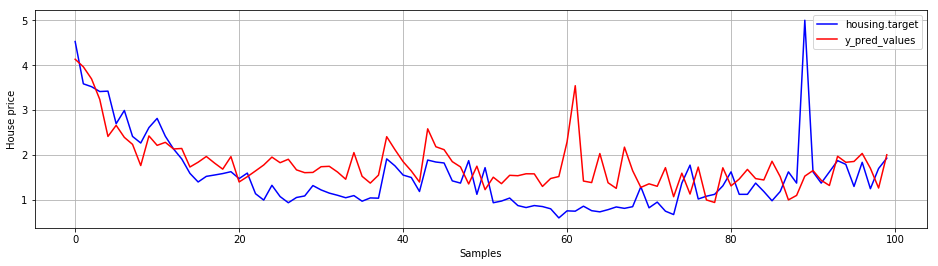

In [16]:
id_sample = range(100);
plt.figure(figsize=(16, 4))
plt.plot(housing.target[id_sample], 'b', label = 'housing.target')
plt.plot(y_pred_value[id_sample], 'r', label = 'y_pred_values')
plt.ylabel('House price')
plt.xlabel('Samples')
plt.legend()
plt.grid(True)
plt.show()

# Using an Optimizer
So TensorFlow computes the gradients for you. But it gets even easier: it also provides a number of optimizers out of the box, including a Gradient Descent optimizer.

In [17]:
# reset the tensorflow graph
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype = tf.float32, name = 'X')
y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = 'y')
theta  =  tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name = 'theta')
y_pred = tf.matmul(X, theta, name = 'predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name = 'mse')

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
#optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9)

training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 200 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    y_pred_value = y_pred.eval()
    best_theta = theta.eval()
print("best_theta:")   
print(best_theta)

Epoch 0 MSE = 10.353619
Epoch 200 MSE = 0.58193564
Epoch 400 MSE = 0.5528055
Epoch 600 MSE = 0.5394949
Epoch 800 MSE = 0.5324641
[[ 2.0685525e+00]
 [ 7.6372272e-01]
 [ 1.3054883e-01]
 [-9.5850743e-02]
 [ 1.4552163e-01]
 [ 6.4350927e-04]
 [-3.8919065e-02]
 [-8.7576121e-01]
 [-8.3656150e-01]]


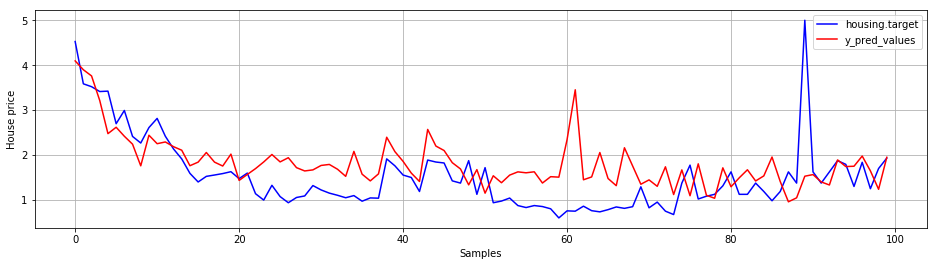

In [18]:
id_sample = range(100);
plt.figure(figsize=(16, 4))
plt.plot(housing.target[id_sample], 'b', label = 'housing.target')
plt.plot(y_pred_value[id_sample], 'r', label = 'y_pred_values')
plt.ylabel('House price')
plt.xlabel('Samples')
plt.legend()
plt.grid(True)
plt.show()

# Feeding Data to the Training Algorithm

Let’s try to modify the previous code to implement `Mini-batch Gradient Descent`. For this, we need a way to replace `X` and `y` at every iteration with the next mini-batch. The simplest way to do this is to use placeholder nodes. 

These nodes are special because they don’t actually perform any computation, they just output the data you tell them to output at runtime. They are typically used to pass the training data to TensorFlow during training. If you don’t specify a value at runtime for a placeholder, you get an exception.

In [19]:
tf.reset_default_graph()

To create a placeholder node, you must call the `placeholder()` function and specify the output tensor’s data type. Optionally, you can also specify its shape, if you want to enforce it. If you specify None for a dimension, it means “any size.” For example, the following code creates a placeholder node A, and also a node B = A + 5.

In [22]:
A = tf.placeholder(tf.float32, shape = (None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict = {A: [[1,2,3]]})
    B_val_2 = B.eval(feed_dict = {A: [[1,2,3], [11,12,13]]})
print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 6.  7.  8.]
 [16. 17. 18.]]


When we evaluate B, we pass a `feed_dict` to the `eval()` method that specifies the value of A. Note that A must have rank 2 (i.e., it must be two-dimensional) and there must be `three columns` (or else an exception is raised), but it can have any number of rows.
```python
with tf.Session() as sess:
    B_val_3 = B.eval(feed_dict = {A: [[1,2]]}) # this is wrong, feed must be three columns
print(B_val_3)
```
<span style="color:red"> ValueError: Cannot feed value of shape (1, 2) for Tensor 'Placeholder_1:0', which has shape '(?, 3)'</span>


To implement Mini-batch Gradient Descent, we only need to tweak the existing code slightly. First change the definition of X and y in the construction phase to make them placeholder nodes:

In [32]:
tf.reset_default_graph() # reset the graph

n_epochs = 1000
learning_rate = 0.01
batch_size = 5000
n_batches = int(np.ceil(m/batch_size))

X = tf.placeholder(tf.float32, shape=(None, n+1), name = 'X') # <-- change
y = tf.placeholder(tf.float32, shape=(None,1), name = 'y')  # <-- change

theta  =  tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name = 'theta')
y_pred = tf.matmul(X, theta, name = 'predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name = 'mse')

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
#optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()


def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = scaled_housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval(feed_dict = {X:scaled_housing_data_plus_bias, y:housing.target.reshape(-1, 1)}))        
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)    
            sess.run(training_op, feed_dict = {X:X_batch, y:y_batch})            
    y_pred_value = y_pred.eval(feed_dict = {X:scaled_housing_data_plus_bias, y:housing.target.reshape(-1, 1)})
    best_theta = theta.eval()

Epoch 0 MSE = 9.287038
Epoch 100 MSE = 0.5911635
Epoch 200 MSE = 0.5375131
Epoch 300 MSE = 0.52706313
Epoch 400 MSE = 0.5248239
Epoch 500 MSE = 0.524431
Epoch 600 MSE = 0.5244101
Epoch 700 MSE = 0.524356
Epoch 800 MSE = 0.52438235
Epoch 900 MSE = 0.524329
best_theta:
[[ 2.068698  ]
 [ 0.8273811 ]
 [ 0.1173541 ]
 [-0.26630503]
 [ 0.3055133 ]
 [-0.00570307]
 [-0.03895358]
 [-0.8988299 ]
 [-0.8705046 ]]


In [33]:
print("best_theta:")   
print(best_theta)

best_theta:
[[ 2.068698  ]
 [ 0.8273811 ]
 [ 0.1173541 ]
 [-0.26630503]
 [ 0.3055133 ]
 [-0.00570307]
 [-0.03895358]
 [-0.8988299 ]
 [-0.8705046 ]]


**-END-**

